# Predicción del consumo

In [1]:
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath("../src"))
from basedatos.conexion_sql import conexion_SQL
from modelos.ModeloML import ModeloML
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline


db = conexion_SQL("DESKTOP-V5VAI95\\SQLEXPRESS")
df = pd.DataFrame(db.consultar("SELECT * FROM Consumo"))

In [2]:
df["lag_1"] = df["MW"].shift(1)
df["lag_24"] = df["MW"].shift(24)
df["lag_168"] = df["MW"].shift(168)
df = df.dropna()
X = df.drop(columns='MW')
y = df['MW']

ML = ModeloML(X, y)

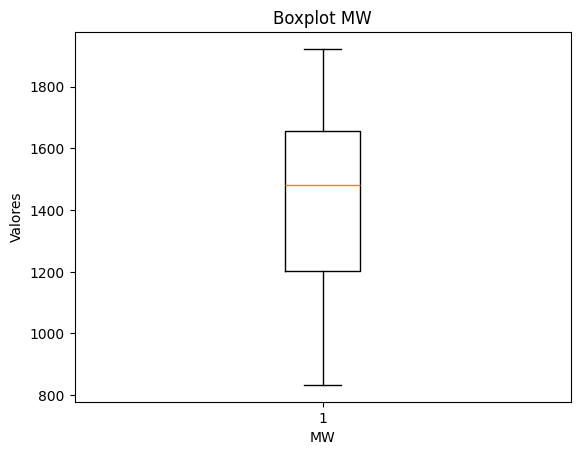

In [3]:
ML.ver_outliers()

In [4]:
ML.evaluar_modelos(models={
                    "Linear": Pipeline([("scaler", StandardScaler()), ("model", LinearRegression())]),
                    "KNN": Pipeline([("scaler", StandardScaler()), ("model", KNeighborsRegressor())]),
                    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
                })

               MAE       RMSE        R2
Linear   36.471496  47.915558  0.963096
KNN      55.002742  72.922686  0.914523
XGBoost  17.521713  24.702887  0.990191


MAE - Mean Absolute Error (Error Absoluto Medio): Representa cuántos MW se equivoca el modelo en promedio. En este caso se equivoca aproximamente un 1% respecto al promedio.

RMSE – Root Mean Squared Error (Raíz del Error Cuadrático Medio): Similar al MAE, pero penaliza más los errores grandes.

R² – Coeficiente de determinación: Es de 0 a 1 y muestra la varianza explicada por el modelo. En este caso es del 99%

In [5]:
parametros = ML.mejores_parametros(XGBRegressor(objective='reg:squarederror',random_state=123,tree_method='hist'))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores parametros:
{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 400}

Mejor MAE:
17.42912761743029


In [6]:
modelo = ML.entrenar_modelo(XGBRegressor(
    **parametros, 
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist'
)
)

MAE final: 14.106990185069272
RMSE final: 19.753641305385862


In [7]:
modelo.predict(pd.DataFrame([{
    'cloud_cover': 0,
    'precipitation': 0,
    'apparent_temperature': 30,
    'wind_speed_10m': 0,
    'sunshine_duration': 3600,
    'mes': 1,
    'dia_mes': 15,
    'hora':  12,
    'dia_sem': 1,
    'anio': 2023,
    'lag_1': 1200,
    'lag_24': 1290,
    'lag_168': 1300
}])
)

array([1289.5538], dtype=float32)